# 1.3: Wall-to-Wall DEM Tile Acquisition

**Objective:** To programmatically identify and download all required 1-arcsecond (≈30m) resolution Digital Elevation Model (DEM) tiles from the USGS S3 repository that cover the study's geomorphic provinces.

**Methodology:**
1.  **Define AOI:** Load the final study area polygons from `study_area_provinces.gpkg`.
2.  **Optimize Selection:** Perform a spatial intersection to identify the exact set of 1x1 degree tiles needed, avoiding the download of unnecessary data within the AOI's bounding box.
3.  **Pre-flight Check:** Scan the local disk to determine which tiles are already present and which are missing.
4.  **Dynamic Parallel Download:**
    - **System Interrogation:** Automatically determine the optimal number of concurrent download threads based on the host machine's physical CPU cores.
    - **Robust Acquisition:** Use a persistent HTTP session with retries to download all missing tiles in parallel, writing to temporary files to prevent corruption.
5.  **Post-flight Check:** Verify final coverage and report any tiles that could not be found or downloaded.

In [1]:
# === 1. Configuration & Setup ===
# This cell contains all user-configurable parameters for the workflow.

# --- Core Libraries ---
import os
import re
import sys
import math
import time
import requests
import geopandas as gpd
import psutil
from pathlib import Path
from shapely.ops import unary_union
from shapely.geometry import box

# --- Robust Path Resolution ---
def find_project_root(marker='README.md'):
    """Find the project root by searching upwards for a marker file."""
    path = Path.cwd().resolve()
    while path.parent != path:
        if (path / marker).exists():
            return path
        path = path.parent
    raise FileNotFoundError(f"Project root with marker '{marker}' not found.")

PROJECT_ROOT = find_project_root()
DATA_DIR = PROJECT_ROOT / "data"
PROC_DIR = DATA_DIR / "processed"
# CORRECTED: Set the final, precise output directory name.
DEM_OUT_DIR = PROC_DIR / "dem_1arcsec_tiles" # Changed from dem_1arcsec
DEM_OUT_DIR.mkdir(parents=True, exist_ok=True)


# --- System-Aware Parallelism (Dynamic Resource Allocation) ---
PHYSICAL_CORES = psutil.cpu_count(logical=False)
# REFINED: Leave one core free for OS responsiveness, ensuring at least 1 worker.
MAX_CONCURRENT_DOWNLOADS = max(1, PHYSICAL_CORES - 1)


# --- Study Area Source ---
PROVINCES_GPKG = PROC_DIR / "study_area_provinces.gpkg"
PROVINCES_LAYER = "provinces"
PROVINCES_TO_COVER = "ALL"  # Or a list like ["PIEDMONT", "BLUE_RIDGE"]

# --- Downloader Behavior ---
RETRY_LIMIT = 3
TIMEOUT_SEC = 60
DRY_RUN = False  # If True, prints actions without downloading files.

# --- USGS S3 Source Configuration (1-Arcsecond / 30m) ---
S3_BASE_URL = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1"
S3_URL_PATTERNS = [
    "TIFF/{key}/USGS_1_{key}.tif", "TIFF/current/{key}/USGS_1_{key}.tif",
    "GeoTIFF/{key}/USGS_1_{key}.tif", "TIFF/{key}/USGS_NED_1_{key}.tif",
    "TIFF/current/{key}/USGS_NED_1_{key}.tif", "TIFF/{key}/USGS_1_{key}.zip",
    "TIFF/current/{key}/USGS_1_{key}.zip",
]

# --- Global Session for HTTP Requests ---
DL_SESSION = requests.Session()
DL_SESSION.headers.update({
    "User-Agent": f"UGA-Geomorphology-TDA/1.0 (Contact: {os.getenv('USER', 'user')}@uga.edu; Research Project)",
})

# --- Print Setup Summary ---
print("--- Configuration Summary ---")
print(f"Project Root:       {PROJECT_ROOT}")
print(f"Data Directory:     {DATA_DIR}")
print(f"Output DEMs:        {DEM_OUT_DIR}")
print(f"Concurrent Workers: {MAX_CONCURRENT_DOWNLOADS} (Based on {PHYSICAL_CORES} physical cores, 1 reserved)")
print("-" * 29)

--- Configuration Summary ---
Project Root:       D:\OneDrive - University of Georgia\multiscale_tda_geomorphology
Data Directory:     D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data
Output DEMs:        D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\processed\dem_1arcsec_tiles
Concurrent Workers: 13 (Based on 14 physical cores, 1 reserved)
-----------------------------


In [2]:
# === DL-01: Utils (bytes, ETA, file scanning, keys) ===
def _human_bytes(n):
    if n is None: return "0 B"
    units = ["B","KB","MB","GB","TB"]
    i = 0
    while n >= 1024 and i < len(units)-1:
        n /= 1024.0; i += 1
    return f"{n:.2f} {units[i]}"

def _eta_from_bytes(num_bytes, mbps):
    if not num_bytes or not mbps: return None
    seconds = (num_bytes * 8) / (mbps * 1_000_000)
    m, s = divmod(int(seconds), 60)
    return f"{m}m {s}s"

# file name → key (e.g., 'USGS_1_n35w079.tif' or 'n35w079.tif')
_KEY_RE = re.compile(r"(?i)(?:USGS_1_|USGS_NED_1_)?([ns]\d{2}[ew]\d{3})")

def _key_from_name(name: str):
    m = _KEY_RE.search(name)
    return m.group(1).lower() if m else None

def disk_tile_keys(folder: Path):
    keys = set()
    for p in folder.glob("**/*"):
        if p.suffix.lower() in (".tif",".tiff",".zip"):
            k = _key_from_name(p.name)
            if k: keys.add(k)
    return keys

def key_from_lon_lat(lon: float, lat: float) -> str:
    hemi_ns = "n" if lat >= 0 else "s"
    hemi_ew = "e" if lon >= 0 else "w"
    return f"{hemi_ns}{abs(int(lat)):02d}{hemi_ew}{abs(int(lon)):03d}"

def keys_from_aoi_bounds(bounds):
    minx, miny, maxx, maxy = map(float, bounds)
    keys = []
    for lon in range(math.floor(minx), math.ceil(maxx)):
        for lat in range(math.floor(miny), math.ceil(maxy)):
            keys.append(key_from_lon_lat(lon, lat))
    return sorted(set(keys))

In [3]:
# === 2. Identify Required DEM Tiles via Spatial Analysis ===

print("Loading study area polygons...")
if not PROVINCES_GPKG.exists():
    raise FileNotFoundError(f"Missing study area file: {PROVINCES_GPKG}")

gdf_provinces = gpd.read_file(PROVINCES_GPKG, layer=PROVINCES_LAYER)
aoi_geom = unary_union(gdf_provinces.geometry)
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_geom], crs=gdf_provinces.crs).to_crs("EPSG:4326")
print(f"Loaded and dissolved {len(gdf_provinces)} province polygons into a single AOI.")

# --- Spatially derive the list of required 1x1 degree tiles ---
# This is a critical optimization. Instead of downloading all tiles in the AOI's
# bounding box, we generate a grid of all possible tiles and keep only those
# that actually intersect the true AOI geometry.
print("Performing spatial intersection to find required tile keys...")
minx, miny, maxx, maxy = aoi_gdf.total_bounds
lons = range(math.floor(minx), math.ceil(maxx))
lats = range(math.floor(miny), math.ceil(maxy))

tile_geoms = [box(lon, lat, lon + 1, lat + 1) for lon in lons for lat in lats]
tile_keys = [key_from_lon_lat(lon, lat) for lon in lons for lat in lats]
candidate_tiles_gdf = gpd.GeoDataFrame({"key": tile_keys}, geometry=tile_geoms, crs="EPSG:4326")

# Perform the spatial join
intersecting_tiles = gpd.sjoin(candidate_tiles_gdf, aoi_gdf, how="inner", predicate="intersects")
required_keys = sorted(intersecting_tiles["key"].unique())

print(f"Identified {len(required_keys)} required tiles (vs. {len(candidate_tiles_gdf)} in bounding box).")
print(f"Skipping {len(candidate_tiles_gdf) - len(required_keys)} unnecessary downloads.")

Loading study area polygons...
Loaded and dissolved 6 province polygons into a single AOI.
Performing spatial intersection to find required tile keys...
Identified 382 required tiles (vs. 1113 in bounding box).
Skipping 731 unnecessary downloads.


In [4]:
# === 3. Pre-flight Check: Compare Required vs. On-Disk Tiles ===

print("Scanning local directory for existing tiles...")
on_disk_keys = disk_tile_keys(DEM_OUT_DIR)
missing_keys = sorted(set(required_keys) - on_disk_keys)

print("\n--- Coverage Summary ---")
print(f"   Tiles Required: {len(required_keys)}")
print(f"    Tiles On Disk: {len(on_disk_keys)}")
print(f"    Tiles Missing: {len(missing_keys)}")

if not missing_keys:
    print("\n✅ All required tiles are already on disk. No download needed.")
else:
    print(f"\nSample of missing keys: {missing_keys[:10]}")

Scanning local directory for existing tiles...

--- Coverage Summary ---
   Tiles Required: 382
    Tiles On Disk: 0
    Tiles Missing: 382

Sample of missing keys: ['n24w081', 'n24w082', 'n24w083', 'n25w081', 'n25w082', 'n25w098', 'n26w081', 'n26w082', 'n26w083', 'n26w098']


In [5]:
# === 4. S3 Probe & Parallel Download Functions ===
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

def _head_ok(url: str, timeout: int = 15):
    """Checks if a URL is valid using a HEAD request, with a Range GET fallback."""
    try:
        r = DL_SESSION.head(url, allow_redirects=True, timeout=timeout)
        if r.status_code in (403, 405): # HEAD not allowed, try a tiny GET
            r = DL_SESSION.get(url, headers={"Range": "bytes=0-0"}, stream=True, timeout=timeout)
        return r.status_code == 200
    except requests.RequestException:
        return False

def build_download_jobs(keys_to_find: list) -> tuple:
    """
    Probes S3 for valid URLs and returns a tuple of (jobs_to_run, not_found_keys).
    """
    jobs = []
    not_found_keys = []
    print(f"\nProbing S3 for download URLs for {len(keys_to_find)} missing tiles...")

    for key in tqdm(keys_to_find, desc="S3 Probe", unit="key"):
        found_url = False
        for pattern in S3_URL_PATTERNS:
            url = f"{S3_BASE_URL}/{pattern.format(key=key)}"
            if _head_ok(url):
                filename = f"USGS_1_{key}.tif"
                jobs.append({"url": url, "out_path": DEM_OUT_DIR / filename, "key": key})
                found_url = True
                break
        if not found_url:
            not_found_keys.append(key)

    if not_found_keys:
        print(f"\n- Probe complete. Could not find valid URLs for {len(not_found_keys)} keys.")
        print(f"  (This is expected for ocean tiles). Sample: {not_found_keys[:5]}")

    return jobs, not_found_keys

def _download_job(job: dict, stats: dict):
    """Worker function to download a single file based on job details."""
    url = job["url"]
    out_path = job["out_path"]
    params = job.get("params")  # Safely get params; will be None for tile mode

    # Skip if the file already exists.
    if out_path.exists() and not DRY_RUN:
        with stats["lock"]:
            stats["skipped"] += 1
        return f"SKIP (exists): {out_path.name}"

    if DRY_RUN:
        return f"DRY_RUN: Would download to {out_path.name}"

    # Retry logic for network requests
    for attempt in range(1, RETRY_LIMIT + 1):
        try:
            with DL_SESSION.get(url, params=params, stream=True, timeout=TIMEOUT_SEC) as r:
                r.raise_for_status()
                # Stream to a temporary .part file to prevent corruption on interruption
                tmp_path = out_path.with_suffix(out_path.suffix + ".part")
                with open(tmp_path, "wb") as f:
                    for chunk in r.iter_content(chunk_size=1 << 20):  # 1MB chunks
                        f.write(chunk)
                # Rename to final path only on success
                tmp_path.rename(out_path)
            return f"OK: {out_path.name}"
        except requests.RequestException as e:
            if attempt < RETRY_LIMIT:
                time.sleep(2 * attempt)
            else:
                return f"FAIL: {out_path.name} ({e})"
    return f"FAIL (retries exhausted): {out_path.name}"


def _execute_downloads(jobs: list, description: str):
    """Executes a list of download jobs in parallel with a progress bar."""
    if not jobs:
        print(f"No new files to download for {description}.")
        return

    stats = {"lock": threading.Lock(), "skipped": 0}
    print(f"⬇️  Starting parallel download for {len(jobs)} {description} files...")

    # CORRECTED: Use the variable MAX_CONCURRENT_DOWNLOADS defined in the config cell.
    with ThreadPoolExecutor(max_workers=MAX_CONCURRENT_DOWNLOADS) as pool:
        future_to_job = {pool.submit(_download_job, job, stats): job for job in jobs}

        results = []
        for future in tqdm(as_completed(future_to_job), total=len(jobs), desc=description, unit="file"):
            results.append(future.result())

    failures = [r for r in results if r.startswith("FAIL")]
    if failures:
        print(f"\n⚠️  Completed with {len(failures)} failures:")
        for fail in failures[:10]: # Print first 10
            print(f"  - {fail}")

    print(f"\n✅ Download process complete. Skipped {stats['skipped']} existing files.")

C:\Users\mkerr\anaconda3\envs\multiscale_tda_geomorphology\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Probing S3 for download URLs for 382 missing tiles...


S3 Probe: 100%|██████████| 382/382 [01:15<00:00,  5.03key/s]


- Probe complete. Could not find valid URLs for 29 keys.
  (This is expected for ocean tiles). Sample: ['n24w081', 'n24w082', 'n24w083', 'n26w083', 'n27w097']

--- Download Plan ---


,id,downloadURL
0,n25w081,https://prd-tnm.s3.amazonaws.com/StagedProduct...
1,n25w082,https://prd-tnm.s3.amazonaws.com/StagedProduct...
2,n25w098,https://prd-tnm.s3.amazonaws.com/StagedProduct...
3,n26w081,https://prd-tnm.s3.amazonaws.com/StagedProduct...
4,n26w082,https://prd-tnm.s3.amazonaws.com/StagedProduct...


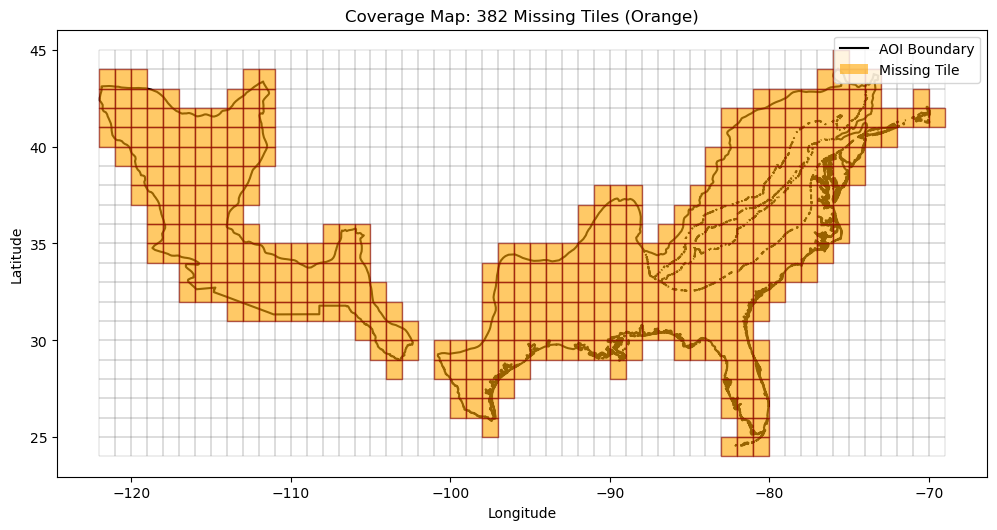

⬇️  Starting parallel download for 353 DEM Tiles files...


DEM Tiles: 100%|██████████| 353/353 [09:29<00:00,  1.61s/file]


✅ Download process complete. Skipped 0 existing files.


In [6]:
# === 5. Execute Download Workflow ===

if __name__ == "__main__" and 'ipykernel' in sys.modules and missing_keys:
    # 1. Build the list of download jobs by probing S3
    download_jobs, unavailable_keys = build_download_jobs(missing_keys)

    # [ The rest of Cell 7 remains the same ]

    if download_jobs:
        # 2. (Optional) Display a preview of the download plan
        df_plan = pd.DataFrame([{"id": j["key"], "downloadURL": j["url"]} for j in download_jobs])
        print("\n--- Download Plan ---")
        display(df_plan.head())

        # 3. (Optional) Plot the missing tiles
        fig, ax = plt.subplots(figsize=(12, 8))
        aoi_gdf.boundary.plot(ax=ax, color="k", linewidth=1.5, zorder=2)
        candidate_tiles_gdf.plot(ax=ax, facecolor="none", edgecolor='gray', linewidth=0.2, zorder=1)
        # Highlight missing tiles
        missing_geoms = candidate_tiles_gdf[candidate_tiles_gdf['key'].isin(missing_keys)].geometry
        gpd.GeoDataFrame(geometry=missing_geoms).plot(ax=ax, facecolor="orange", edgecolor="darkred", alpha=0.6, zorder=3)
        ax.set_title(f"Coverage Map: {len(missing_keys)} Missing Tiles (Orange)")
        ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
        legend_elements = [
            Line2D([0],[0], color="k", lw=1.5, label="AOI Boundary"),
            Rectangle((0,0),1,1, facecolor="orange", alpha=0.6, label="Missing Tile"),
        ]
        ax.legend(handles=legend_elements, loc='best')
        plt.show()

        # 4. Execute the downloads
        if not DRY_RUN:
            _execute_downloads(download_jobs, "DEM Tiles")
        else:
            print("\nDRY_RUN is enabled. No files will be downloaded.")
    else:
        print("\nProbe complete. No downloadable files found for the missing keys.")

---- Coverage (post-download) ----
Tiles required: 382
 Tiles on disk: 353
 Still missing: 29 (Unavailable from source)

Sample of unavailable keys: ['n24w081', 'n24w082', 'n24w083', 'n26w083', 'n27w097', 'n28w090', 'n28w096', 'n29w084', 'n29w085', 'n29w086', 'n29w089', 'n29w091']


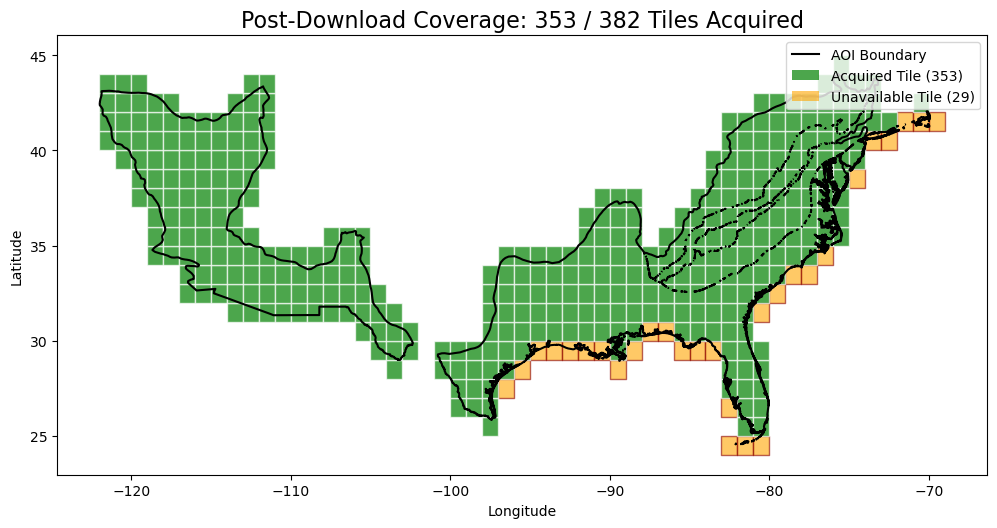

In [9]:
# === 6. Post-flight Check: Final Coverage Verification ===

on_disk_keys = disk_tile_keys(DEM_OUT_DIR)
missing_after = sorted(set(required_keys) - on_disk_keys)

# --- Text Summary ---
print("---- Coverage (post-download) ----")
print(f"Tiles required: {len(required_keys)}")
print(f" Tiles on disk: {len(on_disk_keys)}")
print(f" Still missing: {len(missing_after)} (Unavailable from source)")

if missing_after:
    print("\nSample of unavailable keys:", missing_after[:12])
else:
    print("\n✅ All required tiles are now on disk.")

# --- Map Visualization ---
fig, ax = plt.subplots(figsize=(12, 8))
aoi_gdf.boundary.plot(ax=ax, color="k", linewidth=1.5, zorder=3, label="AOI Boundary")

# Plot acquired tiles in green
acquired_geoms = candidate_tiles_gdf[candidate_tiles_gdf['key'].isin(on_disk_keys)].geometry
gpd.GeoDataFrame(geometry=acquired_geoms).plot(ax=ax, facecolor="green", edgecolor="white", alpha=0.7, zorder=2)

# Plot unavailable tiles in orange
unavailable_geoms = candidate_tiles_gdf[candidate_tiles_gdf['key'].isin(missing_after)].geometry
gpd.GeoDataFrame(geometry=unavailable_geoms).plot(ax=ax, facecolor="orange", edgecolor="darkred", alpha=0.6, zorder=1)

ax.set_title(f"Post-Download Coverage: {len(on_disk_keys)} / {len(required_keys)} Tiles Acquired", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Create custom legend
legend_elements = [
    Line2D([0],[0], color="k", lw=1.5, label="AOI Boundary"),
    Rectangle((0,0),1,1, facecolor="green", alpha=0.7, label=f"Acquired Tile ({len(on_disk_keys)})"),
    Rectangle((0,0),1,1, facecolor="orange", alpha=0.6, label=f"Unavailable Tile ({len(missing_after)})")
]
ax.legend(handles=legend_elements, loc='best')
plt.show()